## Create annotated videos (detection, tracking)

In [5]:
import os
import cv2
import json
import sys
from retinaface import RetinaFace
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image
from scipy.stats import entropy
import logging
from pathlib import Path
import torch
from torchvision import transforms
logging.basicConfig(level=logging.INFO)
# pip install retina-face
# pip install tf-keras
# pip uninstall tensorflow
# pip install tensorflow==2.15.0

### Check videos before task

In [2]:
import cv2
import os

def check_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return False
    
    ret, frame = cap.read()
    if not ret:
        print(f"Error reading first frame from: {video_path}")
        cap.release()
        return False
    
    print(f"Successfully opened and read from: {video_path}")
    print(f"Video properties:")
    print(f"Frame count: {int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}")
    print(f"FPS: {cap.get(cv2.CAP_PROP_FPS)}")
    print(f"Resolution: {int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))}x{int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))}")
    
    cap.release()
    return True

def check_videos_in_directory(video_dir):
    successful_loads = []
    failed_loads = []
    
    for filename in os.listdir(video_dir):
        if filename.endswith('.mp4'):
            full_path = os.path.join(video_dir, filename)
            print(f"\nChecking {filename}:")
            if check_video(full_path):
                successful_loads.append(full_path)
            else:
                failed_loads.append(full_path)
    
    print("\nSummary:")
    print(f"Successfully loaded videos: {len(successful_loads)}")
    print(f"Failed to load videos: {len(failed_loads)}")
    
    return successful_loads, failed_loads

# Directory containing your video files
video_dir = '/notebooks/data/original'  # Adjust this path as needed

successful, failed = check_videos_in_directory(video_dir)

print("\nSuccessfully loaded video paths:")
for path in successful:
    print(path)

print("\nFailed to load video paths:")
for path in failed:
    print(path)


Checking PwNQ-K0pzkc.mp4:
Successfully opened and read from: /notebooks/data/original/PwNQ-K0pzkc.mp4
Video properties:
Frame count: 23129
FPS: 25.0
Resolution: 1280x720

Checking 0jpRxldMUSw.mp4:
Successfully opened and read from: /notebooks/data/original/0jpRxldMUSw.mp4
Video properties:
Frame count: 951
FPS: 25.0
Resolution: 1280x720

Checking HrWlKN1DSYo.mp4:
Successfully opened and read from: /notebooks/data/original/HrWlKN1DSYo.mp4
Video properties:
Frame count: 15209
FPS: 25.0
Resolution: 480x360

Checking 4L5Yv6gADuM.mp4:
Successfully opened and read from: /notebooks/data/original/4L5Yv6gADuM.mp4
Video properties:
Frame count: 1039
FPS: 25.0
Resolution: 1280x720

Checking p3p-yrf9lIQ.mp4:
Successfully opened and read from: /notebooks/data/original/p3p-yrf9lIQ.mp4
Video properties:
Frame count: 9919
FPS: 25.0
Resolution: 640x360

Checking hb2T6yD5t7M.mp4:
Successfully opened and read from: /notebooks/data/original/hb2T6yD5t7M.mp4
Video properties:
Frame count: 25476
FPS: 25.0
R

[mov,mp4,m4a,3gp,3g2,mj2 @ 0xdc165c0] moov atom not found


Successfully opened and read from: /notebooks/data/original/ABgL2LcoBTU.mp4
Video properties:
Frame count: 883
FPS: 25.0
Resolution: 1280x720

Checking PE-NqycWE4M.mp4:
Successfully opened and read from: /notebooks/data/original/PE-NqycWE4M.mp4
Video properties:
Frame count: 12560
FPS: 25.0
Resolution: 1280x720

Checking IDhn63EjlEg.mp4:
Successfully opened and read from: /notebooks/data/original/IDhn63EjlEg.mp4
Video properties:
Frame count: 1086
FPS: 25.0
Resolution: 1280x720

Checking 1DeV3HTdWTI.mp4:
Successfully opened and read from: /notebooks/data/original/1DeV3HTdWTI.mp4
Video properties:
Frame count: 6241
FPS: 25.0
Resolution: 640x360

Checking QGEU99l9HoA.mp4:
Successfully opened and read from: /notebooks/data/original/QGEU99l9HoA.mp4
Video properties:
Frame count: 15003
FPS: 25.0
Resolution: 1280x720

Checking OhbfvD0Cwvw.mp4:
Successfully opened and read from: /notebooks/data/original/OhbfvD0Cwvw.mp4
Video properties:
Frame count: 19650
FPS: 25.0
Resolution: 1280x720

Check

### GOTURN specific imports

In [3]:
sys.path.append("/notebooks/goturn-pytorch/src")

from goturn.helper.BoundingBox import BoundingBox
from goturn.helper.image_proc import cropPadImage
from goturn.helper.image_io import resize
from goturn.network.network import GoturnNetwork

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### GOTURN modified script v2

In [4]:
def fallback_track_matching(track, current_detections, iou_threshold=0.2):
    best_iou = iou_threshold
    best_detection = None
    for detection in current_detections:
        iou = compute_iou(track['bbox'], detection['bbox'])
        if iou > best_iou:
            best_iou = iou
            best_detection = detection
    return best_detection




if __name__ == "__main__":
    ckpt_path = "/notebooks/goturn-pytorch/src/goturn/models/pretrained/_ckpt_epoch_3.ckpt"
    goturn_model = load_goturn_model(ckpt_path)
    file_name = "4L5Yv6gADuM"
    input_path = f"/notebooks/data/original/{file_name}.mp4"
    output_video_path = f"/notebooks/data/annotated_with_goturn/{file_name}2.mp4"
    output_json_path = f"/notebooks/data/annotated_with_goturn/{file_name}2.json"
    # Main execution
    base_dir = os.path.dirname(os.getcwd())  # Go up two levels from the code folder
    original_folder = os.path.join(base_dir, 'data', 'original')
    annotated_folder = os.path.join(base_dir, 'data', 'annotated_with_goturn')
    info_folder = os.path.join(base_dir, 'data', 'annotated', 'info')

    # Ensure output directories exist
    os.makedirs(annotated_folder, exist_ok=True)
    os.makedirs(info_folder, exist_ok=True)
    process_video(input_path, output_video_path, output_json_path, goturn_model)

2024-09-10 18:24:44.066 | INFO     | goturn.network.network:__init__:55 - Not using caffe fc weights/ manually initialized
INFO:root:Loaded state_dict from .ckpt instead.
Processing 4L5Yv6gADuM.mp4:   0%|          | 0/1039 [00:00<?, ?it/s]2024-09-10 18:24:49.157511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-10 18:24:49.163574: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-10 18:24:49.163798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:

24-09-10 18:24:51 - Directory /root/.deepface created
24-09-10 18:24:51 - Directory /root/.deepface/weights created
24-09-10 18:24:51 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5

  0%|          | 0.00/119M [00:00<?, ?B/s]
  8%|▊         | 9.96M/119M [00:00<00:01, 99.5MB/s]
 34%|███▎      | 39.8M/119M [00:00<00:00, 215MB/s] 
 53%|█████▎    | 62.9M/119M [00:00<00:00, 222MB/s]
 72%|███████▏  | 85.5M/119M [00:00<00:00, 196MB/s]
100%|██████████| 119M/119M [00:00<00:00, 217MB/s] 
2024-09-10 18:25:05.496653: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
Processing 4L5Yv6gADuM.mp4: 100%|█████████▉| 1038/1039 [02:38<00:00,  6.54it/s]

Processed 1039 frames
Annotated video saved to /notebooks/data/annotated_with_goturn/4L5Yv6gADuM2.mp4
Face tracks data saved to /notebooks/data/annotated_with_goturn/4L5Yv6gADuM2.json


### Main execution

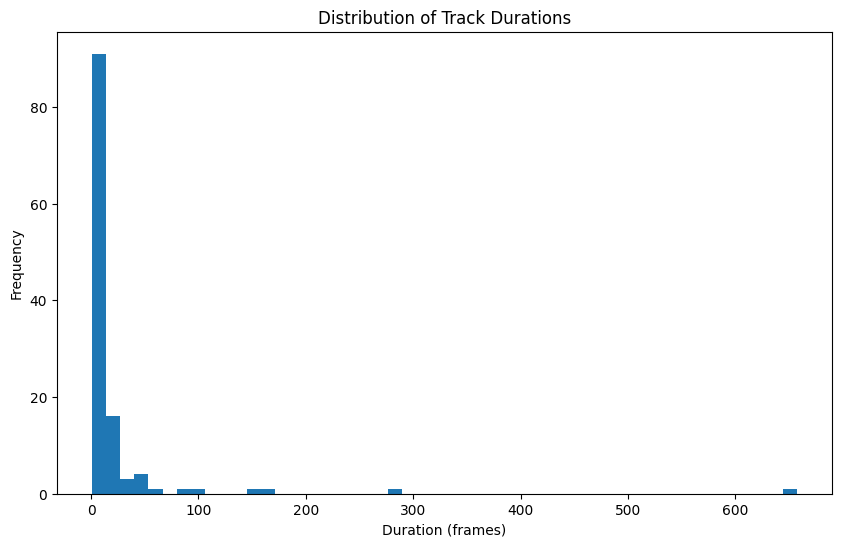

Mean duration: 20.08 frames
Median duration: 3.00 frames
25th percentile: 1.00 frames
75th percentile: 14.00 frames
Suggested threshold for discarding short-lived tracks: 1.00 frames


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

def analyze_track_duration(json_path):
    with open(json_path, 'r') as f:
        json_data = json.load(f)

    track_durations = {}
    for frame, tracks in json_data.items():
        for track in tracks:
            track_id = track['track_id']
            if track_id not in track_durations:
                track_durations[track_id] = {'start': int(frame), 'end': int(frame)}
            else:
                track_durations[track_id]['end'] = int(frame)

    durations = [d['end'] - d['start'] + 1 for d in track_durations.values()]

    plt.figure(figsize=(10, 6))
    plt.hist(durations, bins=50)
    plt.title('Distribution of Track Durations')
    plt.xlabel('Duration (frames)')
    plt.ylabel('Frequency')
    plt.show()

    print(f"Mean duration: {np.mean(durations):.2f} frames")
    print(f"Median duration: {np.median(durations):.2f} frames")
    print(f"25th percentile: {np.percentile(durations, 25):.2f} frames")
    print(f"75th percentile: {np.percentile(durations, 75):.2f} frames")

    return durations

# Usage
json_path = '/notebooks/data/annotated/info/4L5Yv6gADuM.json'
durations = analyze_track_duration(json_path)

# Suggest a threshold (e.g., 25th percentile)
suggested_threshold = np.percentile(durations, 25)
print(f"Suggested threshold for discarding short-lived tracks: {suggested_threshold:.2f} frames")

In [6]:
# Main execution: loop over each of the videos
base_dir = os.path.dirname(os.getcwd())  # Go up two levels from the code folder
original_folder = os.path.join(base_dir, 'data', 'original')
annotated_folder = os.path.join(base_dir, 'data', 'annotated')
info_folder = os.path.join(base_dir, 'data', 'annotated', 'info')

# Ensure output directories exist
os.makedirs(annotated_folder, exist_ok=True)
os.makedirs(info_folder, exist_ok=True)

# Process all .mp4 files in the original folder
for filename in os.listdir(original_folder):
    if filename.endswith(".mp4"):
        input_path = os.path.join(original_folder, filename)
        output_video_path = os.path.join(annotated_folder, filename)
        output_json_path = os.path.join(info_folder, f"{os.path.splitext(filename)[0]}.json")

        # Check if both output files already exist
        if os.path.exists(output_video_path) and os.path.exists(output_json_path):
            print(f"Skipping {filename} as output files already exist.")
            continue

        process_video(input_path, output_video_path, output_json_path)

print("All videos processed successfully!")

Processing PwNQ-K0pzkc.mp4: 100%|██████████| 23129/23129 [33:00<00:00, 11.68it/s]


Processed 23129 frames
Annotated video saved to /notebooks/data/annotated/PwNQ-K0pzkc.mp4
Face tracks data saved to /notebooks/data/annotated/info/PwNQ-K0pzkc.json


Processing 0jpRxldMUSw.mp4: 100%|██████████| 951/951 [01:23<00:00, 11.42it/s]


Processed 951 frames
Annotated video saved to /notebooks/data/annotated/0jpRxldMUSw.mp4
Face tracks data saved to /notebooks/data/annotated/info/0jpRxldMUSw.json


Processing HrWlKN1DSYo.mp4: 100%|██████████| 15209/15209 [15:49<00:00, 16.02it/s]


Processed 15209 frames
Annotated video saved to /notebooks/data/annotated/HrWlKN1DSYo.mp4
Face tracks data saved to /notebooks/data/annotated/info/HrWlKN1DSYo.json


Processing 4L5Yv6gADuM.mp4: 100%|██████████| 1039/1039 [01:33<00:00, 11.10it/s]


Processed 1039 frames
Annotated video saved to /notebooks/data/annotated/4L5Yv6gADuM.mp4
Face tracks data saved to /notebooks/data/annotated/info/4L5Yv6gADuM.json


Processing p3p-yrf9lIQ.mp4: 100%|██████████| 9919/9919 [13:14<00:00, 12.48it/s]


Processed 9919 frames
Annotated video saved to /notebooks/data/annotated/p3p-yrf9lIQ.mp4
Face tracks data saved to /notebooks/data/annotated/info/p3p-yrf9lIQ.json


Processing hb2T6yD5t7M.mp4: 100%|██████████| 25476/25476 [37:53<00:00, 11.21it/s]


Processed 25476 frames
Annotated video saved to /notebooks/data/annotated/hb2T6yD5t7M.mp4
Face tracks data saved to /notebooks/data/annotated/info/hb2T6yD5t7M.json


Processing YFAcgTFOyuM.mp4:   3%|▎         | 302/9045 [00:26<12:41, 11.49it/s]


KeyboardInterrupt: 

### Add back the sound to annotated videos

In [9]:


# Set up paths
base_dir = os.path.dirname(os.getcwd())
original_folder = os.path.join(base_dir, 'data', 'original')
annotated_folder = os.path.join(base_dir, 'data', 'annotated_with_goturn')
output_folder = os.path.join(base_dir, 'data', 'annotated_with_goturn_audio')

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get list of annotated videos
annotated_videos = [f for f in os.listdir(annotated_folder) if f.endswith('.mp4')]

successful = 0
failed = 0

# Process each annotated video
for video in tqdm(annotated_videos, desc="Processing videos"):
    original_video_path = os.path.join(original_folder, video)
    annotated_video_path = os.path.join(annotated_folder, video)
    output_video_path = os.path.join(output_folder, video)
    
    if not os.path.exists(original_video_path):
        print(f"Original video not found for {video}")
        failed += 1
        continue
    
    if add_audio_to_video(original_video_path, annotated_video_path, output_video_path):
        successful += 1
    else:
        failed += 1

print(f"\nProcessing complete.")
print(f"Successfully processed: {successful}")
print(f"Failed to process: {failed}")

# Verify audio streams in output videos
print("\nVerifying audio streams in output videos:")
for video in os.listdir(output_folder):
    video_path = os.path.join(output_folder, video)
    if check_audio_stream(video_path):
        print(f"{video}: Audio stream present")
    else:
        print(f"{video}: No audio stream detected")

Processing videos:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s]

FFmpeg output for /notebooks/data/annotated_with_goturn_audio/4L5Yv6gADuM.mp4:

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora -

Processing videos: 100%|██████████| 2/2 [00:04<00:00,  2.45s/it]

FFmpeg output for /notebooks/data/annotated_with_goturn_audio/p3p-yrf9lIQ.mp4:

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora -